In [17]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

%matplotlib inline

In [18]:
folder = '/home/moritz/Workspace/masterthesis/data/identities/'
df = pd.read_csv(folder + 'team_10/2023-01-10/team_10_2023-01-10.csv')

In [19]:
preprocessing_pipeline = [
    LinearInterpolator(),
    RollingAverageSmoother(
        window_size=125,
        cols=["Brightness"],
    ),
]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(df)

pre_df.head(10)

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,ClassID
0,0,0.859231,311.330200,257.052216,0.011517,0.000328,0.027729,0.003560,0.115143,0.000633,0.841090,130.218030,person_id1
1,5,0.861641,311.069519,257.257812,0.027471,0.000938,0.021004,0.014420,0.049442,0.002902,0.883825,130.208162,person_id1
2,10,0.864387,310.401337,257.077698,0.013858,0.000590,0.020718,0.011206,0.054205,0.002150,0.897274,130.199746,person_id1
3,15,0.857088,309.180542,257.192322,0.007874,0.000331,0.019181,0.010273,0.267788,0.001857,0.692697,130.191170,person_id1
4,20,0.863373,308.937561,256.899963,0.023433,0.005211,0.023248,0.119337,0.020521,0.001587,0.806663,130.175980,person_id1
5,25,0.861514,308.977722,256.862000,0.016282,0.002679,0.018116,0.129328,0.052434,0.001255,0.779906,130.155277,person_id1
6,30,0.860861,309.119141,256.857361,0.018370,0.002227,0.017883,0.074440,0.075149,0.003630,0.808302,130.128426,person_id1
7,35,0.861749,309.200684,256.914490,0.009426,0.001639,0.012532,0.106760,0.043058,0.004981,0.821604,130.105227,person_id1
8,40,0.862883,309.130066,256.918396,0.017765,0.002002,0.016394,0.072357,0.051905,0.003857,0.835720,130.087816,person_id1
9,45,0.864287,309.477448,257.314697,0.008124,0.001638,0.018537,0.032498,0.142708,0.013917,0.782577,130.076158,person_id1


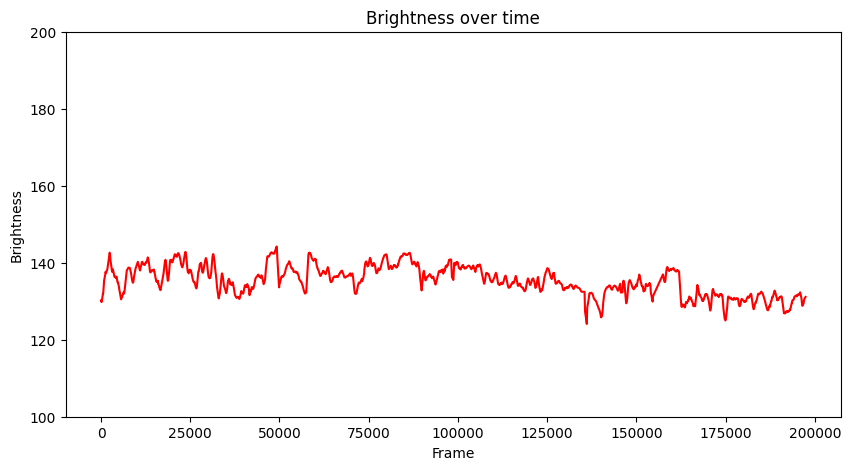

In [20]:
person_df = pre_df[pre_df["ClassID"] == "person_id1"]

# create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# plot the Brightness column for person_id1 using sns.lineplot()
sns.lineplot(x="Frame", y="Brightness", data=person_df, color="red")

# set the title, x-label, y-label, and y-limits of the plot
ax.set_title("Brightness over time")
ax.set_xlabel("Frame")
ax.set_ylabel("Brightness")
ax.set_ylim(100, 200)

plt.show()

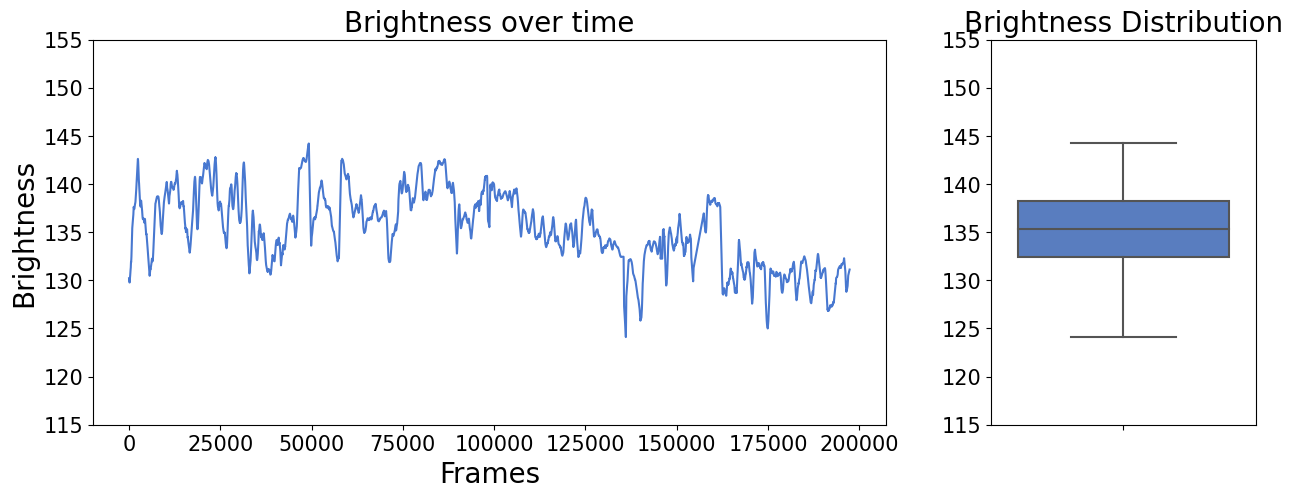

In [24]:
person_df = pre_df[pre_df["ClassID"] == "person_id1"]

# Create a custom color palette
palette = sns.color_palette("muted", n_colors=4)

# create a new figure and axis
fig, axs = plt.subplots(ncols=2, figsize=(15, 5), gridspec_kw={"width_ratios": [3, 1]})

# plot the Brightness column for person_id1 using sns.lineplot()
sns.lineplot(x="Frame", y="Brightness", data=person_df, color=palette[0], ax=axs[0])

# set the title, x-label, y-label, and y-limits of the line plot
axs[0].set_title("Brightness over time", fontsize=20)
axs[0].set_xlabel("Frames", fontsize=20)
axs[0].set_ylabel("Brightness", fontsize=20)
axs[0].set_ylim(115, 155)

# plot the boxplot for person_id1 using sns.boxplot()
sns.boxplot(y="Brightness", data=person_df, color=palette[0], ax=axs[1])

# set the title, y-label, and y-limits of the boxplot
axs[1].set_title("Brightness Distribution", fontsize=20)
axs[1].set_ylabel("", fontsize=1)
axs[1].set_ylim(115, 155)

# remove the x-tick labels from the boxplot
axs[1].set_xticklabels([])
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=15)

path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
image = path + "/brightness.pdf"
plt.savefig(image, bbox_inches='tight', dpi=300)

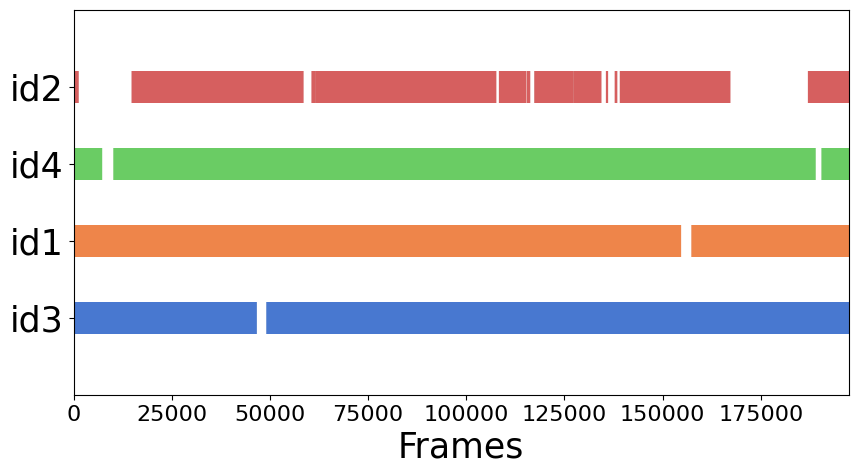

In [22]:
# get the unique ClassIDs
class_ids = df['ClassID'].unique()
# Create a custom color palette
palette = sns.color_palette("muted", n_colors=4)

# create a figure and axis object with custom width and height
fig, ax = plt.subplots(figsize=(10, 5))

# plot the presence of each ClassID in each frame
for i, class_id in enumerate(class_ids):
    is_present = df['ClassID'] == class_id
    ax.scatter(df[is_present]['Frame'], [i] * len(df[is_present]), marker='|', s=500, label=class_id , color=palette[i % len(palette)])

# set the y-axis ticks and labels
ax.set_yticks(range(len(class_ids)))
ax.set_yticklabels([class_id.split("_")[1] for class_id in class_ids])

# reduce the spacing between yticks
ax.set_ylim(-1.0, len(class_ids))

# set the x-axis label and limits
ax.set_xlabel('Frames', fontsize=25)
ax.set_xlim(0, df['Frame'].max() + 1)
ax.set_ylim(-1, 4)

# set the x-tick labels and y-tick labels font size
ax.tick_params(axis='y', which='major', labelsize=25)
ax.tick_params(axis='x', which='major', labelsize=16)

# show the legend and plot
path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
image = path + "/presence.pdf"
plt.savefig(image, bbox_inches='tight', dpi=300)




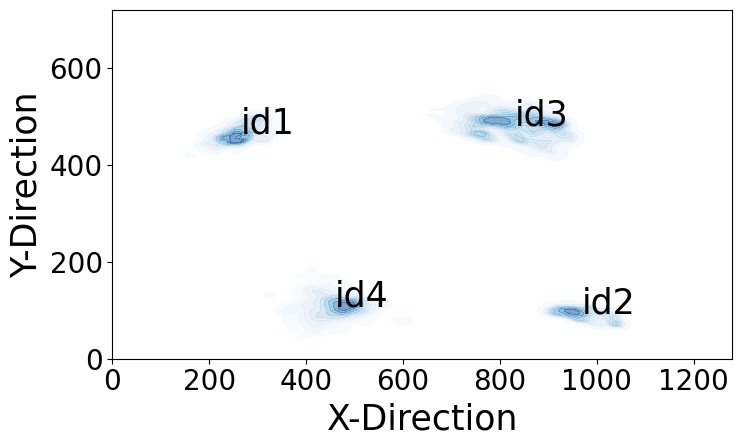

In [23]:
df["y_center"] = -df["y_center"] + 720

# Plot the KDEs in a single plot
fig, ax = plt.subplots(figsize=(8, 8))

for class_id in df["ClassID"].unique():
    sns.kdeplot(
        ax=ax,
        data=df[df["ClassID"] == class_id],
        x="x_center",
        y="y_center",
        cmap="Blues",
        alpha=0.5,
        thresh=0.05,
        fill=True,
    )
    ax.text(
        x=df[df["ClassID"] == class_id]["x_center"].mean(),
        y=df[df["ClassID"] == class_id]["y_center"].mean(),
        s=class_id.split("_")[1],
        fontsize=25,
    )

# Set the aspect ratio to make x- and y-axis the same size
ax.set_aspect("equal")

ax.set_xlabel("X-Direction", fontsize=25)
ax.set_ylabel("Y-Direction", fontsize=25)
ax.set_xlim(0, 1280)
ax.set_ylim(0, 720)
ax.tick_params(axis='both', which='major', labelsize=20)

path = "/home/moritz/Dropbox (Personal)/Dropbox/Apps/Overleaf/tum-thesis-latex/data/05_results"
image = path + "/space.pdf"
plt.savefig(image, bbox_inches='tight', dpi=300)
